# Mastère DMS : Méthodes Numériques
## Résolution de systèmes linéaires

@author : Basile Marchand (basile.marchand@mines-paristech.fr)

On considère une matrice de rigidité associée à un système de ressorts. L'énergie potentielle $E(\mathbf{x})$ est la somme des énergies de chaque ressort reliant $x_i$ à $x_j$, moins le travail des efforts extérieurs (ici $x_N \: F$):
$$ E(\mathbf{x}) = \sum_{i=1}^N \frac{1}{2} k \: \left(x_{L(i,1)} - x_{L(i,2)}\right)^2 + \frac{1}{2} k \: x_1^2 - x_N\: F $$
$L(k,:)$ est la table de connectivité indiquant les points d'accroche des ressorts.

* Construire une fonction `build_system( F, k, N)` construisant la matrice $\mathbf{K}$ et le second membre $\mathbf{F}$.
* Commenter le profil de la matrice
* Étudier le temps de calcul de la factorisation pour $N=10,100,500,1000,5000,10000$
* Comment peut on augmenter la largeur  de bande de la matrice ?
* Alors faite le
* Refaire l'étude des temps de factorisation
* Comment peut-on tirer parti de la structure de la matrice ?

### Correction dans le cas de ressort homogène et de matrice pleine 

In [21]:
import numpy as np
import time

In [22]:
def build_system(connec, k, fext, n):
    K =  np.zeros((n,n))
    for spring in connec:
        kelem =  np.array([[k,-k],[-k,k]])
        K[np.ix_(spring,spring)] = K[np.ix_(spring,spring)] +  kelem

    F = np.zeros((n,1))
    F[n-1] =  fext
    return K, F

**Construction de la table de connectivité pour des ressorts en séries**

In [33]:
L = [ [i,i+1] for i in range(9) ]

Appel de la fonction `build_system`

In [34]:
K,F = build_system(L, 1., 1., 10)

On peut alors remarquer que le système à résoudre est singulier. Cela est du au fait que l'on a pour le moment pas pris en compte les conditions aux limites. $u_0 = 0$. Pour prendre en compte la condition aux limites il faut supprimer la première ligne et première colonne du système linéaire. 

In [35]:
u = np.linalg.solve(K[1:,1:], F[1:])
u_homogene = np.zeros( (u.shape[0]+1, 1))
u_homogene[1:] = u 
print(u)

[[1.]
 [2.]
 [3.]
 [4.]
 [5.]
 [6.]
 [7.]
 [8.]
 [9.]]


### Prise en compte d'une rigidité variable entre les ressorts

Pour prendre en compte la possibilité d'avoir une rigidité différente entre chaque ressort le plus simple est d'ajouter une colonne dans la table de connectivité du système. Nous allons ici considérer des valeurs aléatoires pour chaque ressort 

In [26]:
L_heterogene = [ [i,i+1, np.random.rand(1)[0] ] for i in range(9) ]

La nouvelle fonction permettant de construire le système s'écrit alors de la manière suivante : 

In [27]:
def build_system_heterogene(connec, fext, n):
    K =  np.zeros((n,n))
    for i, j, k in connec:
        kelem =  np.array([[k,-k],[-k,k]])
        K[np.ix_([i,j],[i,j])] = K[np.ix_([i,j],[i,j])] +  kelem

    F = np.zeros((n,1))
    F[n-1] =  fext
    return K, F

In [28]:
K,F = build_system_heterogene(L_heterogene, 1., 10)
u2 = np.linalg.solve(K[1:,1:], F[1:])
u_heterogene = np.zeros((u2.shape[0]+1,1))
u_heterogene[1:] = u2

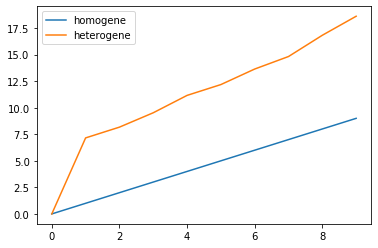

In [38]:
import matplotlib.pyplot as plt 
plt.plot(u_homogene, label="homogene")
plt.plot(u_heterogene, label="heterogene")
plt.legend()
plt.show()

### Ajout de ressort en parallèle

L'ajout de ressort en parallèle se fait simplement en ajoutant des lignes dans la tables de connectivité. Par exemple considérons que l'on ajoute les ressorts reliant les point `i` et `i+2` dans le système. 

In [40]:
### Partie serie 
L = [ [i,i+1, np.random.rand(1)[0] ] for i in range(9) ]
### Ajout de la partie parallèle 
L += [ [i, i+2, np.random.rand(1)[0]] for i in range(8)]

K_parallel, F_parallel = build_system_heterogene(L, 1., 10)

u_tmp = np.linalg.solve(K_parallel[1:,1:], F_parallel[1:])
u_parallel = np.zeros((u_tmp.shape[0]+1,1))
u_parallel[1:] = u_tmp

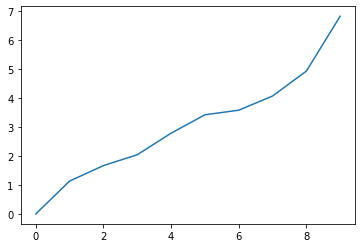

In [42]:
plt.plot(u_parallel)
plt.show()

### Utilisation de matrice sparse


Vous l'avez peut-être remarqué, il y a dans la matrice `K` beaucoup de terme nuls. Il parait donc judicieux d'utiliser pour le stockage de cette matrice une matrice `sparse`. 




In [43]:
import scipy.sparse as sp 
import scipy.sparse.linalg as spl

def build_system_heterogene_sparse(connec, fext, n):
    row_idx = []
    col_idx = []
    data = []
    for i, j, k in connec:
        kelem =  np.array([[k,-k],[-k,k]])
        row_idx += [i, i, j, j]
        col_idx += [i, j, i, j]
        data += kelem.ravel().tolist()

    K = sp.coo_matrix((data, (row_idx, col_idx)) )
    F = np.zeros((n,1))
    F[n-1] =  fext
    return K, F

On peut alors utiliser cette nouvelle fonction pour construire un système linéaire sparse qui sera résolu à l'aide de `spl.spsolve`. Nous devrions alors voir apparaitre l'impact de la largeur de bande sur le temps de résolution du problème linéaire. 

In [57]:
%env OMP_NUM_THREADS=1

# Systeme de 1000 à 50000 ressort 
listN = [1000, 2000, 10000, 50000, 100000]
k = 1.
fext = 1.

offsets = [2,10,50, 100, 300]
times = {"serie" : []}
for off in offsets:
    times[off] = []

for N in listN:
    print(f"Solve for N = {N}")
    
    ## Resolution du probleme de ressort en serie
    L = [ [i,i+1, 1.] for i in range(N-1) ]
    K,F = build_system_heterogene_sparse(L, fext, N)
    K1 = K.tocsc()
    Kk = K1[1:,1:]
    t0 = time.time()
    x = spl.spsolve( Kk, F[1:])
    t1 = time.time()

    times["serie"].append(t1-t0)

    
    ## Resolution des problemes avec ressort en parallèle 
    
    for offset in offsets:
        print(f"  --> offset = {offset}")
        L_offset = L[:]
        L_offset += [[i, i+offset, 1] for i in range(N-offset) ]
        K,F = build_system_heterogene_sparse(L_offset, fext, N)
        K1 = K.tocsc()
        Kk = K1[1:,1:]
        t0 = time.time()
        x = spl.spsolve( Kk, F[1:])
        t1 = time.time()
        times[offset].append(t1-t0)

env: OMP_NUM_THREADS=1
Solve for N = 1000
  --> offset = 2
  --> offset = 10
  --> offset = 50
  --> offset = 100
  --> offset = 300
Solve for N = 2000
  --> offset = 2
  --> offset = 10
  --> offset = 50
  --> offset = 100
  --> offset = 300
Solve for N = 10000
  --> offset = 2
  --> offset = 10
  --> offset = 50
  --> offset = 100
  --> offset = 300
Solve for N = 50000
  --> offset = 2
  --> offset = 10
  --> offset = 50
  --> offset = 100
  --> offset = 300
Solve for N = 100000
  --> offset = 2
  --> offset = 10
  --> offset = 50
  --> offset = 100
  --> offset = 300


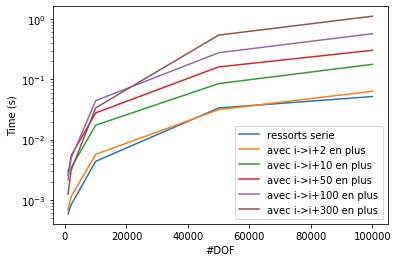

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.semilogy(listN, times["serie"], label='ressorts serie')
for key, value in times.items():
    if key == "serie":
        continue
    plt.semilogy(listN, value, label=f'avec i->i+{key} en plus')

plt.xlabel("#DOF")
plt.ylabel("Time (s)")
plt.legend()
